<a href="https://colab.research.google.com/github/j-caspar/Gender-Disparities-in-the-Labor-Market-A-Machine-Learning-Analysis/blob/main/Final_Project_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS 5450 Final Project - Female Labor Force Participation**
*Jared Caspar, Priya Mehra, Leyla Theunissen*

# Part 1: Introduction

For our final project, we decided to analyze how various statistics can correlate to female labor force participation globally. To do this, we used Health Nutrition and Population Statistics uploaded to Kaggle by the world bank. This dataset included a diverse array of statistics collected across 263 countries/regions on a yearly basis from 1960 to 2016. These statistics center around population, health, immunization, fertility, and more. Some of these statistics were sparsely populated, others were missing only a few values, and others were entirely full. This caused us to have to look at each indicator and see which ones must be dropped entirely and which could be manipulated to give a comprehensive view of its respective country during our selected time period.

Once we had cleaned the data, we were able develop an understanding of what drives (or drags) female labor force participation through the methods explained more thoroughly below.

Our process is detailed below, with each important result or decision being thoroughly discussed in an annotation located above or below each respective cell.


# Part 2: Data Loading and Preprocessing

## Imports

We begin by importing the necessary libraries for each stage of our project, including pre-processing, exploratory data analysis, and model selection. These imports feature pandas, matplotlib, numpy, and sklearn, as well as a few additional libraries (i.e. pycountry) for processing country and continent information.

In [ ]:
# Imports + Installs
!pip install category_encoders
!pip install pycountry
!pip install pycountry-convert
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import folium
import numpy as np
import category_encoders as ce
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import copy
import pycountry
import geopandas as gpd
from xgboost import XGBRegressor
from folium.plugins import HeatMap
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn import datasets, linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from torch.utils import data as data_utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## 2.1 Loading and Analyzing Health, Nutrition, and Population Data

We then downloaded our dataset from Kaggle, an online platform where one can access data sets for exploration and machine learning. Our dataset was one of the recommended datasets for this project, and deals with health, nutrition, and population statistics worldwide.

### 2.1.1 Downloading from Kaggle



In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create kaggle directory
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download data to drive
!!kaggle datasets download -d theworldbank/health-nutrition-and-population-statistics

['health-nutrition-and-population-statistics.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
# Unzip folder in Colab content folder
!unzip /content/health-nutrition-and-population-statistics.zip

Archive:  /content/health-nutrition-and-population-statistics.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### 2.1.2 Converting to DataFrame

In [ ]:
# Read csv into Pandas dataframe
data = pd.read_csv('data.csv')

### 2.1.3 Analyzing Data Structure

Since our data is across many indicators and many countries, it did not make sense to try understanding our data with distribution statistics (i.e. the .describe() function).

Instead, we simply analyzed the datatypes of our columns, the first ten rows of our data, and the unique indicators in the column called 'Indicator Name'. These indicators, although initially stored in one column, would be engineered into independent features and used as the basis of future analyses.

In [ ]:
# Dataframe column datatypes
data.dtypes

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2012              float64
2013              float64
2014              float64
2015              float64
Unnamed: 60       float64
Length: 61, dtype: object

In [ ]:
# First 10 tuples of data
data.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,...,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,Arab World,ARB,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arab World,ARB,Adults (ages 15+) living with HIV,SH.DYN.AIDS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Arab World,ARB,Adults (ages 15+) newly infected with HIV,SH.HIV.INCD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arab World,ARB,"Age at first marriage, female",SP.DYN.SMAM.FE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Arab World,ARB,"Age at first marriage, male",SP.DYN.SMAM.MA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,87.799235,89.221714,90.502403,91.603014,92.414916,92.868163,...,64.630067,63.602627,62.738022,62.053505,61.794943,61.681904,61.678686,61.719792,61.754194,NaN


In [ ]:
# Unique values for indicators
data['Indicator Name'].unique()

array(['% of females ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)',
       '% of males ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Adults (ages 15+) and children (0-14 years) living with HIV',
       'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
       'Adults (ages 15+) living with HIV',
       'Adults (ages 15+) newly infected with HIV',
       'Age at first marriage, female', 'Age at first marriage, male',
       'Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old', 'Age dependency ratio, young',
       'Age population, age 0, female, interpolated',
       'Age population, age 0, male, interpolated',
       'Age population, age 01, female, interpolated',
       'Age population, age 01, male, interpolated',
       'Age popula

## 2.2 Preprocessing Data

After scanning the CSV with our data, we noticed that many of the rows had null values for many years. In order to delineate which indicators would be most usable in future analyses, we decided to filter for the "top indicators" – the indicators with the most number of countries with at least 20 non-null years worth of data. We used 20 as a minimum number of annual data points we needed in order to extract significant trends and predictions from the data. We display the top indicators (in the DataFrame top_indicators) below.

### 2.2.1 Identifying Indicators with Most Data



In [ ]:
# Count the number of non-null values for each indicator-country pair
year_columns = data.columns[4:-1]
non_null_counts = data.groupby(['Indicator Name', 'Country Name'])[year_columns].apply(lambda x: x.notnull().sum(axis=1).sum()).reset_index(name='NonNullYears')

# Filter rows based on number of 'NonNullYears'
top_indicators = non_null_counts[non_null_counts['NonNullYears'] >= 20]

In [ ]:
# Display the indicator-country pairs with more than 20 non-null years of data
top_indicators

,Indicator Name,Country Name,NonNullYears
516,AIDS estimated deaths (UNAIDS estimates),Afghanistan,26
518,AIDS estimated deaths (UNAIDS estimates),Algeria,26
521,AIDS estimated deaths (UNAIDS estimates),Angola,26
524,AIDS estimated deaths (UNAIDS estimates),Argentina,26
525,AIDS estimated deaths (UNAIDS estimates),Armenia,26
...,...,...,...
89003,Women's share of population ages 15+ living wi...,Vietnam,26
89006,Women's share of population ages 15+ living wi...,World,26
89007,Women's share of population ages 15+ living wi...,"Yemen, Rep.",26
89008,Women's share of population ages 15+ living wi...,Zambia,26


In [ ]:
# Count the number of countries with >= 20 non-null years per indicator
countries_per_indicator = top_indicators['Indicator Name'].value_counts()

### 2.2.2 Drop Unnecessary Columns
We then dropped unnecessary columns, namely 'Country Code' and 'Indicator Code', because 'Country Name' and 'Indicator Name' would be sufficient for our analyses. We also narrowed our scope to the years 1980 - 2014 (the last year recorded) because of the overwhelming presence of nulls in the years 1960-1980 and the desire to focus on more recent data.

In [ ]:
# Drop unnecessary columns by name
filtered_df = data.drop(columns=['Country Code', 'Indicator Code', 'Unnamed: 60'])

# Drop unnecessary columns in date range 1960-1980
years_to_drop = [str(year) for year in range(1960, 1980)]
filtered_df = filtered_df.drop(columns=years_to_drop)

### 2.2.3 Dropping Unnecessary Rows + Null Rows

At this point, we actually did not drop null-rows and reserved that filtering for later. The reasoning, which we wanted to mention upfront, was that our filtering would be largely dependent on which indicators we decided to select for further exploration. Only after doing EDA were we able to identify which features would be most relevant for modelling, and thus which features were worth performing additional pre-processing on.

# Part 3: Exploratory Data Analysis


Our EDA enabled us to deepen our understanding of features and the relationships between them. In our exploration, we chose combinations of the features that we thought would be most statistically fruitful for model development, as well as most practical and relevant for applications of our learnings.

Our EDA is composed of **two parts**, each revolving around one of two separate categories: 1) immunization, and 2) female labor force participation. After exploring the data in both categories, we decided to move forward with female labor force participation as the ultimate focus of our model development.

## 3.1 EDA on Immunization Data

### 3.1.1 Setting up DataFrame and Indicators

Before we narrowed the scope of our project to female labor force participation, we intended to analyze the relationship between immunizations, mortality, and overall public health. We were hoping that we could quantify the impact of vaccinations within and across regions.

To do this, we first initialized a list of features that we deemed most relevant to the theme of immunization. Some were features on immunization rates explicitly, while others seemed sufficiently adjacent to include in a potential model.

In [ ]:
model1_indicators = ['Number of infant deaths',
                     'Mortality rate, infant (per 1,000 live births)',
                     'Birth rate, crude (per 1,000 people)',
                     'Immunization, BCG (% of one-year-old children)',
                     'Immunization, DPT (% of children ages 12-23 months)',
                     'Immunization, HepB3 (% of one-year-old children)',
                     'Immunization, Hib3 (% of children ages 12-23 months)',
                     'Immunization, measles (% of children ages 12-23 months)',
                     'Immunization, Pol3 (% of one-year-old children)',
                     'Physicians (per 1,000 people)',
                     'Average Infant Immunization']


immunization_indicators = [
    'Immunization, BCG (% of one-year-old children)',
    'Immunization, DPT (% of children ages 12-23 months)',
    'Immunization, HepB3 (% of one-year-old children)',
    'Immunization, Hib3 (% of children ages 12-23 months)',
    'Immunization, measles (% of children ages 12-23 months)',
    'Immunization, Pol3 (% of one-year-old children)'
]

In [ ]:
# Create dataframe for model 1
model1_df = filtered_df[filtered_df['Indicator Name'].isin(model1_indicators)]

### 3.1.2 Engineering Average Imumunization Indicator

Then, we engineered a new feature called 'Average Infant Immunization' that took the average of the all immunization rates stored in the list of 'immunization_indicators' for every country. All individual immunizations were equally weighted in the average. We felt comfortable taking the average since most of the immunization rates were consistent across each vaccine for a given country in a given year

In [ ]:
vaccination_df = model1_df[model1_df['Indicator Name'].isin(immunization_indicators)]
average_vaccination_df = vaccination_df.groupby('Country Name').mean(numeric_only=True).reset_index()
average_vaccination_df['Indicator Name'] = 'Average Infant Immunization'
if 'Average Infant Immunization' not in filtered_df['Indicator Name'].values:
  model1_df = pd.concat([model1_df, average_vaccination_df], ignore_index=True, sort=False)

### 3.1.3 Average Infant Mortality and Immunization Rates

First, we took a global average of infant mortality rates and infant immunization rates per year. We then plotted both results on the same graph in order to visualize the relationship between them. This plot attempts not to analyze country-specific data, but to understand broad relationships between these two key features and their evolution over time.

In [ ]:
# Filter rows for desired Indicator Name(s)
mortality_rate_df = model1_df[model1_df['Indicator Name'] == 'Mortality rate, infant (per 1,000 live births)']
vaccination_rate_df = model1_df[model1_df['Indicator Name'] == 'Average Infant Immunization']

# Drop unnecessary columns
mortality_rate_df = mortality_rate_df.drop(['Country Name', 'Indicator Name'], axis=1)
vaccination_rate_df = vaccination_rate_df.drop(['Country Name', 'Indicator Name'], axis=1)

# Calculate the average mortality rate and average vaccination rate per year across all countries
average_mortality_rate = mortality_rate_df.mean(axis=0)
average_vaccination_rate = vaccination_rate_df.mean(axis=0)

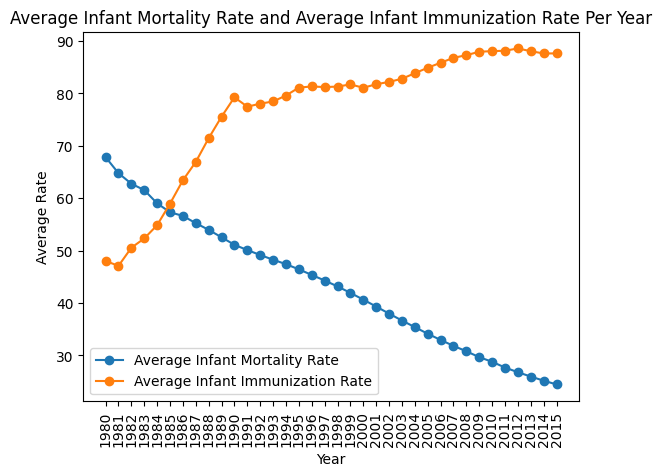

In [ ]:
# SCATTER: AVERAGE MORTALITY RATE AND AVERAGE INFANT Immunization (ACROSS ALL COUNTRIES) VS. YEA

# Create a line plot for the average mortality rate
plt.plot(average_mortality_rate.index, average_mortality_rate.values, marker='o', label='Average Infant Mortality Rate')
plt.plot(average_vaccination_rate.index, average_vaccination_rate.values, marker='o', label='Average Infant Immunization Rate')

# Add title, axes labels, and legend
plt.title('Average Infant Mortality Rate and Average Infant Immunization Rate Per Year')
plt.xlabel('Year')
plt.ylabel('Average Rate')
plt.xticks(rotation=90)
plt.legend()

plt.show()

Takeaways:


*   As expected, average infant mortality rate and immunization rate are inversely correlated. (We cannot infer anything about causation.)
*   Average infant immunization rate overtook average infant mortality rate in 1986.
*   Average infant immunization rate levels off at around 90% in more recent years.





### 3.1.4 Mortality Rate vs. Average BCG Immunization

Next, we used a scatterplot to visualize how mortality rate varies with average BCG immunization in each country. The BCG (Bacillus Calmette–Guérin) vaccine is an immunization against tuberculosis.

Each point in the scatterplot represents one country's data, averaged across all years in the range 1980-2015. Once again, the purpose here is not to analyze country-specific data, but to observe a general relationship between mortality rate and immunization (here, BCG).

<ipython-input-102-92bee36e5ea2>:10: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-102-92bee36e5ea2>:13: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



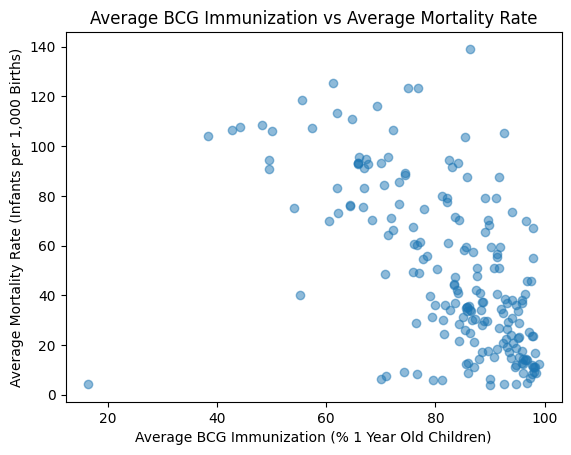

In [ ]:
# SCATTER: MORTALITY RATE VS. AVERAGE BCG IMMUNIZATION

# Filter rows where Indicator Name is 'Mortality rate, infant (per 1,000 live births)'
mortality_rate_df = model1_df[model1_df['Indicator Name'] == 'Mortality rate, infant (per 1,000 live births)']

# Filter rows where Indicator Name is 'Immunization, BCG (% of one-year-old children)'
bcg_immunization_df = model1_df[model1_df['Indicator Name'] == 'Immunization, BCG (% of one-year-old children)']

# Calculate the average immunization, BCG for each country
average_bcg_df = bcg_immunization_df.groupby('Country Name').mean()

# Calculate the average mortality rate for each country
average_mortality_df = mortality_rate_df.groupby('Country Name').mean()

# Take the average across all years for each country for both rates
average_bcg_overall = average_bcg_df.mean(axis=1)
average_mortality_overall = average_mortality_df.mean(axis=1)

# Create a DataFrame with the averages
averages_df = pd.DataFrame({
    'Average Immunization, BCG': average_bcg_overall,
    'Average Mortality Rate': average_mortality_overall
})

# Plot a scatter plot
plt.scatter(averages_df['Average Immunization, BCG'], averages_df['Average Mortality Rate'], alpha=0.5)
plt.title('Average BCG Immunization vs Average Mortality Rate')
plt.xlabel('Average BCG Immunization (% 1 Year Old Children)')
plt.ylabel('Average Mortality Rate (Infants per 1,000 Births)')
plt.show()


Takeaways:


*   Mortality rate and BCG immunization rates are inversely correlated for most countries.
*   While there is not so much variation in average BCG immunization, there is still meaningful variation in mortality rates between countries.



### 3.1.5 Mortality Rate vs. All Immunizations

Rather than plotting mortality rate against a single immunization, such as BCG, this plot compares mortality rate with various immunization rates across countries. The x-axis shows different immunizations, each represented in a different color, and the y-axis shows mortality rate.

This scatter plot aims to explore potential differences between immunization rates and their relationships with mortality rate.

<ipython-input-103-ccfe9946a4d4>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-103-ccfe9946a4d4>:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-103-ccfe9946a4d4>:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-103-ccfe9946a4d4>:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default

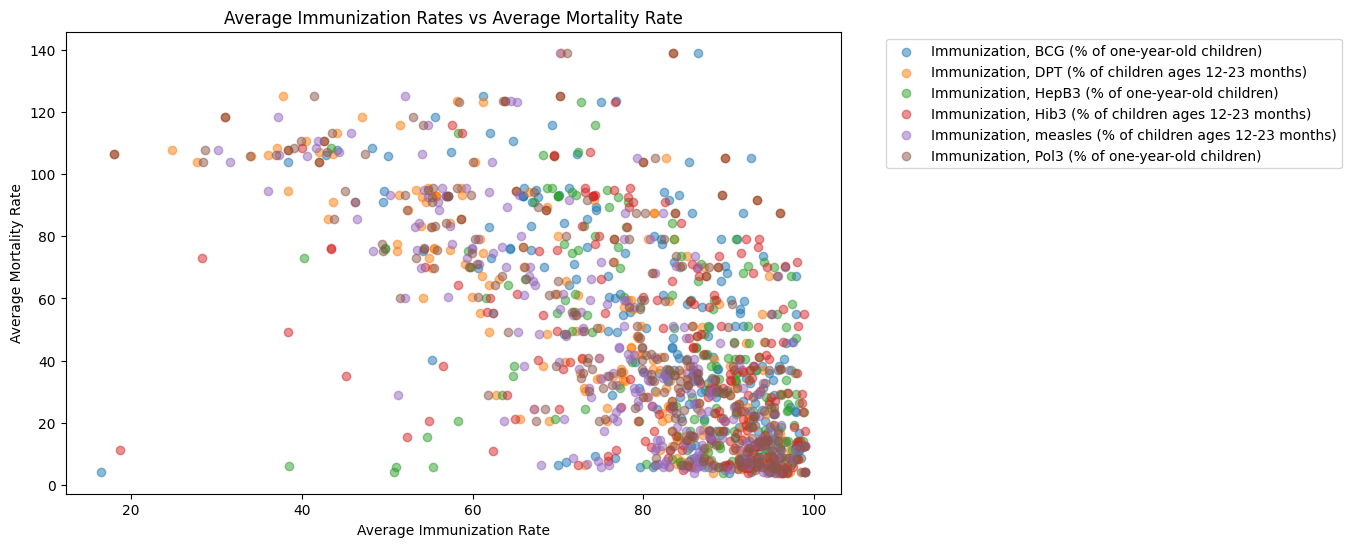

In [ ]:
# SCATTER: MORTALITY RATE VS. ALL DIFFERENT IMMUNIZATIONS

# Calculate the average mortality rate for each country across all years
mortality_rate_df = model1_df[model1_df['Indicator Name'] == 'Mortality rate, infant (per 1,000 live births)']
average_mortality_df = mortality_rate_df.groupby('Country Name').mean()
average_mortality_overall = average_mortality_df.mean(axis=1)

# For each immunization rate indicator, calculate the average for each country across all years
average_immunization_dfs = []
for indicator in immunization_indicators:
    immunization_df = model1_df[model1_df['Indicator Name'] == indicator]
    average_immunization_df = immunization_df.groupby('Country Name').mean()
    average_immunization_overall = average_immunization_df.mean(axis=1)
    average_immunization_dfs.append(average_immunization_overall)


# Create a df with all the averages
averages_df = pd.DataFrame({'Average Mortality Rate': average_mortality_overall})
for i, indicator in enumerate(immunization_indicators):
    averages_df[f'Average Immunization_{i+1}'] = average_immunization_dfs[i]

# Plot a scatter plot
plt.figure(figsize=(10, 6))

# Plot mortality rate against each immunization rate (each in a different color)
for i, indicator in enumerate(immunization_indicators):
    plt.scatter(
        averages_df[f'Average Immunization_{i+1}'], # Used numbers for names to avoid renaming issues
        averages_df['Average Mortality Rate'],
        alpha=0.5,
        label=f'{indicator}',
    )

plt.title('Average Immunization Rates vs Average Mortality Rate')
plt.xlabel('Average Immunization Rate')
plt.ylabel('Average Mortality Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Takeaways:


*   Different immunizations show very similar relationships (all inverse) to mortality rate, similar to that demonstrated by BCG immunization.



### 3.1.6 Individual Immunizations vs. Average Immunization

Here, we examine the relationship between specific immunization rates and overall average immunization rate (as engineered earlier in our EDA) across countries. The x-axis displays different specific immunization rates, while the y-axis shows the overall average immunization rate.

<ipython-input-104-298721a8ef3d>:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-104-298721a8ef3d>:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-104-298721a8ef3d>:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-104-298721a8ef3d>:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to

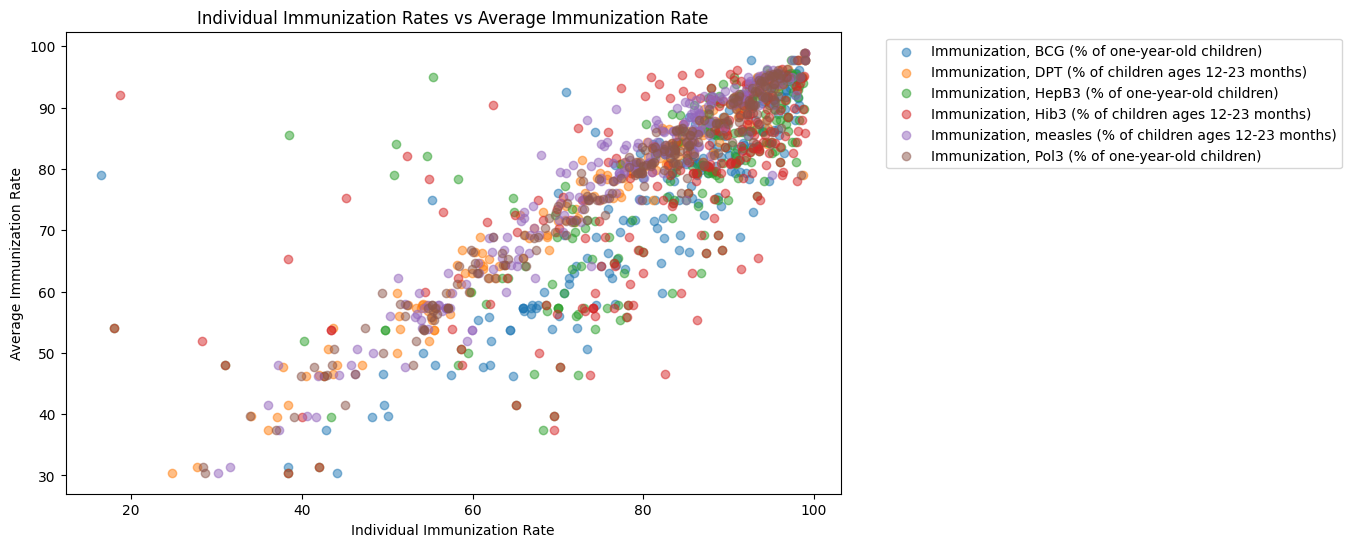

In [ ]:
# SCATTER: SPECIFIC IMMUNIZATIONS VS. AVERAGE OVERALL IMMUNIZATION

# For each immunization rate, calculate the average for each country across all years
average_immunization_dfs = []
for indicator in immunization_indicators:
    immunization_df = model1_df[model1_df['Indicator Name'] == indicator]
    average_immunization_df = immunization_df.groupby('Country Name').mean()
    average_immunization_overall = average_immunization_df.mean(axis=1)
    average_immunization_dfs.append(average_immunization_overall)

# Calculate the average "Average Infant Immunization" rate for each country across all years
average_immunization_df = model1_df[model1_df['Indicator Name'] == 'Average Infant Immunization']
average_immunization_df = average_immunization_df.groupby('Country Name').mean()
average_immunization_overall = average_immunization_df.mean(axis=1)

# Create a df with the averages
averages_df = pd.DataFrame({'Average Immunization Rate': average_immunization_overall})
for i, indicator in enumerate(immunization_indicators):
    averages_df[f'Average {indicator}'] = average_immunization_dfs[i]

# Plot a scatter plot
plt.figure(figsize=(10, 6))

# Plot each specific immunization rate (each in different color) against the 'Average Infant Immunization'
for i, indicator in enumerate(immunization_indicators):
    plt.scatter(
        averages_df[f'Average {indicator}'],
        averages_df['Average Immunization Rate'],
        alpha=0.5,
        label=f'{indicator}',
    )

plt.title('Individual Immunization Rates vs Average Immunization Rate')
plt.xlabel('Individual Immunization Rate')
plt.ylabel('Average Immunization Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Takeaways:


*   Individual immunization rates generally share the same linear relationship with the average immunization rate in every country.
*   A few immunizations, including BCG (in blue) and Hib3 (in red), show generally higher rates compared to average.



### 3.1.7 Average Number of Physicians

This plot simply aims to visualize the number of physicians in every country, as grouped into buckets of size 1. The motivation is that number of physicians might correlate with immunization rates as it might be a limiting factor on vaccine distribution. The y-axis shows the number of countries that fall into each bin on the x-axis, representing average number of physicians.

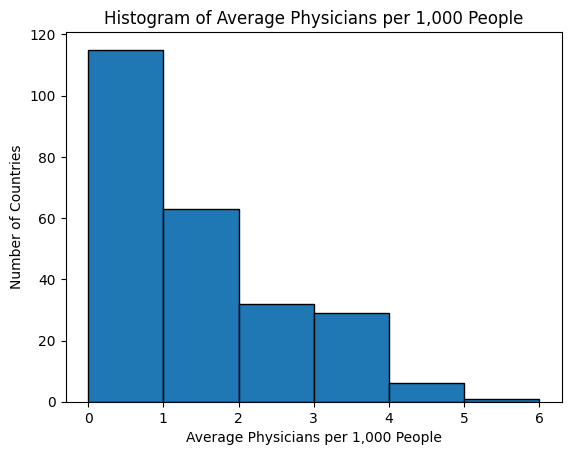

In [ ]:
# HISTOGRAM: NUMBER OF COUNTRIES VS. AVERAGE # OF PHYSICIANS

physicians_df = model1_df[model1_df['Indicator Name'] == 'Physicians (per 1,000 people)']

# Drop unnecessary columns
physicians_df = physicians_df.drop(['Country Name', 'Indicator Name'], axis=1)

# Calculate the average number of physicians per country across all years
average_physicians = physicians_df.mean(axis=1)

# Create a histogram with bins of size 1
plt.hist(average_physicians, bins=range(int(average_physicians.min()), int(average_physicians.max()) + 1), edgecolor='black')
plt.title('Histogram of Average Physicians per 1,000 People')
plt.xlabel('Average Physicians per 1,000 People')
plt.ylabel('Number of Countries')
plt.show()

Takeaways:


*   Most countries have between 0 and 1 physician per 1,000 people.
*   The maximum number of physicians per 1,000 people is between 5 and 6.



### 3.1.8 Heap Map over Immunization Indicators

We then created a heat map over all over immunization indicators in an attempt
to understand the relationship between each pairwise set of two variables. We noticed that the correlations between immunizations were extremely positive and high and that correlations between immunizations and mortality rate were negative and relatively high as well, which corroborates our earlier EDA results. We accredit some of the lower correlations to the amount of null values in our data.

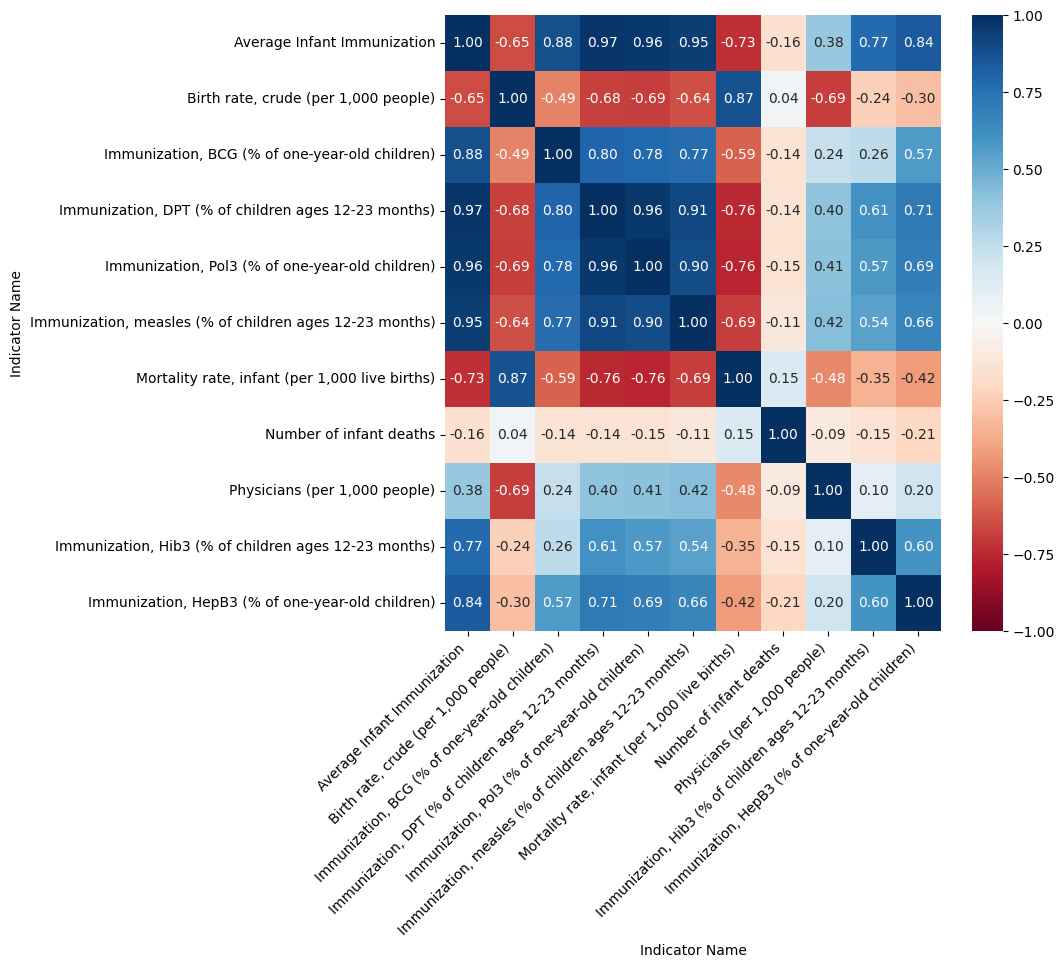

In [ ]:
# HEAT MAP: IMMUNIZATION DATA, BIRTH RATES, NUMBER OF INFANT DEATHS, AND PHYSICIANS

# Transpose model 1 df so indicators are columns
model1_transposed = model1_df.pivot_table(index=['Country Name'], columns='Indicator Name')
di = {}
for i in model1_transposed.columns.levels[0]:
    di[i] = model1_transposed[i]
model1_transposed_df = pd.concat(di.values()).reset_index()

# Drop unnecessary columns
model1_transposed_df.drop(columns=['Country Name'], inplace=True)

# Create heatmap
plt.figure(figsize=(8,8))
fig = sns.heatmap(data = model1_transposed_df.corr(), cmap = 'RdBu', vmin = -1, vmax = 1, annot = True, fmt=".2f")
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## 3.2 EDA on Female Labor Force Participation Data
At this point, we made the choice to pivot our project to female labor force participation. Our vaccine EDA indicated that the relationship between vaccines, mortality, and overall public health was relatively straightforward and not in need of further analysis. Due to the co-occurrence of vaccines and their uniform impact on mortality, we realized that after running a PCA, we would get an extremely low number of components, making our analysis uninteresting and far too simple. By changing our topic to a more complicated concept, female labor force participation, we were hoping to discover more nuanced relationships between features.

### 3.2.1 Setting up DataFrame and Indicators
We first initialized a list of features that we deemed most relevant to the theme of female labor participation. These features related to fertility, marriage, GNI (gross national income), school enrollment, unemployment, and illness. Since all of our indicators are in one column (with years as other columns), we transposed our dataframe to get a row for each country-indicator pair in a given year. We also noticed there were many null entries for the earlier years in our dataset (1980-1991).

In [ ]:
# Create dataframe for model 2
model2_indicators = [
    'Labor force, female (% of total labor force)',
    'Life expectancy at birth, female (years)',
    'Fertility rate, total (births per woman)',
    'Adolescent fertility rate (births per 1,000 women ages 15-19)',
    'School enrollment, secondary, female (% gross)',
    'Public spending on education, total (% of GDP)',
    'Unemployment, total (% of total labor force)',
    'School enrollment, tertiary, female (% gross)',
    'Rural population (% of total population)',
    'Lifetime risk of maternal death (%)',
    'GNI per capita, Atlas method (current US$)',
    'Age at first marriage, female',
    'Age dependency ratio (% of working-age population)',
    'Women’s share of population ages 15+ living with HIV(%)',
    'Population ages 15-64, female (% of total)'
]
model2_df = filtered_df[filtered_df['Indicator Name'].isin(model2_indicators)]
years_to_drop = [str(year) for year in range(1980, 1991)]
model2_df = model2_df.drop(columns=years_to_drop)
model2_df = model2_df.drop(columns = ['2015'])

In [ ]:
# Transpose model 2 df so indicators are columns
model2_transposed = model2_df.pivot_table(index=['Country Name'], columns='Indicator Name')
di = {}
for i in model2_transposed.columns.levels[0]:
    di[i] = model2_transposed[i]
model2_df = pd.concat(di.values()).reset_index()

### 3.2.2 Female Labor Participation by Regionality

#### 3.2.2.1 Filtering for Continent Data Based on Country
Next, we used pycountry_convert in order to add a continent columnn to the dataframe. We wanted to incorporate regionality in our analysis, since we hypothesized that female labor force participation and our features would vary enormously across different geographic regions. With that being said, having the country as a feature would not be sensical, as we would have to perform a one-hot encoding, which would introduce far too many features (almost 200). So, we dropped the country name and instead focused on the continent, seeking to better generalize regional trends.

In [ ]:
# Add in continent data
import pycountry_convert as pc

# use pycountry_convert to get the continent that corresponds to each country
def country_to_continent(country_name):
  try:
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
  except (AttributeError, KeyError):
    return None

# drop all columns which don't have a continent
filtered_df['Continent'] = filtered_df['Country Name'].apply(country_to_continent)
model2_df['Continent'] = model2_df['Country Name'].apply(country_to_continent)
filtered_df = filtered_df.dropna(subset=['Continent'])
model2_df = model2_df.dropna(subset=['Continent'])

In [ ]:
# Average female labor force in the past decade for more simple EDA
years = [str(year) for year in range(2004, 2015)]
continent = filtered_df[filtered_df['Indicator Name'] == 'Labor force, female (% of total labor force)']
continent['Female Labor Force 2004-2014'] = continent[years].mean(axis=1, skipna=True)
country_counts = continent.groupby('Continent').size().reset_index(name='Number of Countries')
continent = continent.groupby('Continent').mean().reset_index()
continent = continent[['Continent', 'Female Labor Force 2004-2014']]

<ipython-input-110-de610175e819>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-110-de610175e819>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



#### 3.2.2.2 Female Agricultural Labor by Continent
Now that we calculated continent data, we wanted to plot female labor participation (FLP) across each continent. We calculated the average FLP rate in the past decade as well as the average percentage of working women in the agricultural sector, also in the past decade. We sought to understand how workforce participation differed across each continent as a whole.

In [ ]:
# Analysis of female labor statistics in agriculture
continent_agriculture = filtered_df[(filtered_df['Indicator Name'] == 'Share of women employed in the nonagricultural sector (% of total nonagricultural employment)')]
continent_agriculture['Women not in Agriculture 2004-2014'] = continent_agriculture[years].mean(axis=1, skipna=True)
country_counts_ag = continent_agriculture.groupby('Continent').size().reset_index(name='Number of Countries')
continent_agriculture = continent_agriculture.groupby('Continent').mean().reset_index()
continent_agriculture = continent_agriculture[['Continent', 'Women not in Agriculture 2004-2014']]

# Calculate the percentage of women working in the nonagricultural sector relative to the total female labor force
continent_agriculture['Women in Agriculture'] = 100 - continent_agriculture['Women not in Agriculture 2004-2014']

<ipython-input-111-5b9cdce8388e>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-111-5b9cdce8388e>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



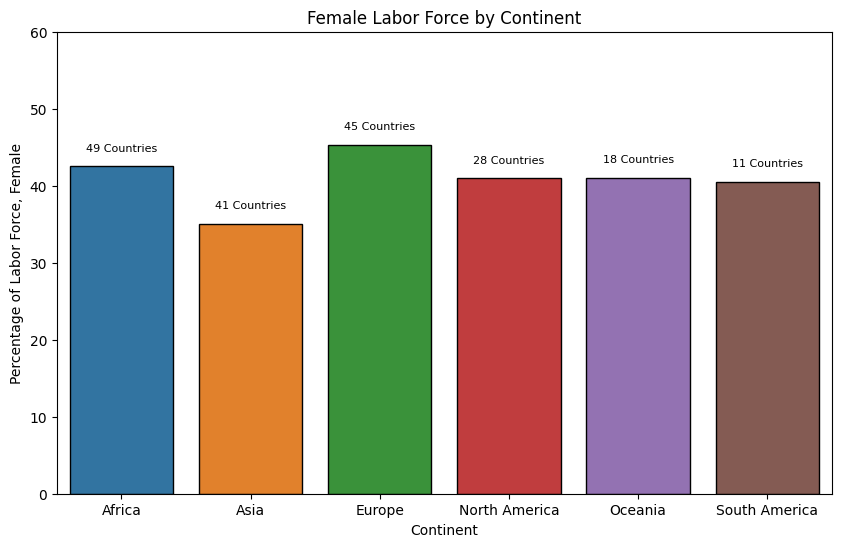

In [ ]:
# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bar graph for the average female labor force
plot = sns.barplot(x='Continent', y='Female Labor Force 2004-2014', data=continent, ax=ax, label='Percent of labor force, female', capsize=0.1, edgecolor='black')

# # Plotting the bar graph for the normalized women in nonagricultural sector
bar_heights = [bar.get_height() for bar in plot.patches]

# add number of countries
for i, (num_countries, height) in enumerate(zip(country_counts['Number of Countries'], bar_heights)):
    ax.text(i, height + 3, f'{num_countries} Countries',
            ha='center', va='top', color='black', fontsize=8)

# Adding labels and title
ax.set_xlabel('Continent')
ax.set_ylabel('Percentage of Labor Force, Female')
ax.set_title('Female Labor Force by Continent')
ax.set_ylim(top=60)

# Show the plot
plt.show()

To our surprise, there was little variation across female labor force participation for each continent. We thought that certain continents with more progressive gender policies and workplaces (e.g. Europe and North America), would have a greater percentage of working women, but this was barely the case. To see if we could find other differences in the female labor force across continents, we looked into how the type of work differed across each continent (agricultural vs. non-agricultural labor).

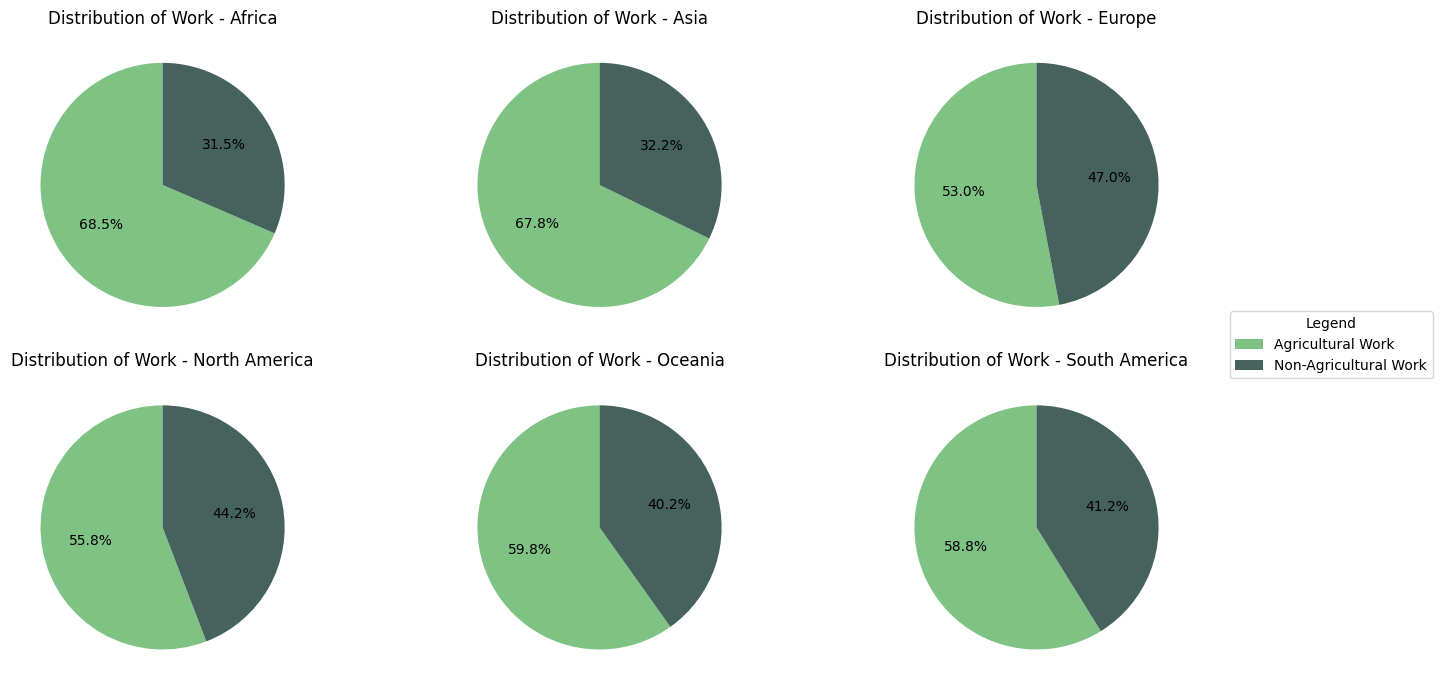

In [ ]:
# Create a figure with 6 subplots for agricultural vs. non-agricultural work
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))

# iterate through each continent
for i, continent_name in enumerate(continent['Continent'].unique()):
    ax = axes[i // 3, i % 3]

    # Filter data for the current continent
    continent_data = continent_agriculture[continent_agriculture['Continent'] == continent_name]

    # Plot pie chart
    wedges, texts, autotexts = ax.pie(continent_data[['Women in Agriculture', 'Women not in Agriculture 2004-2014']].iloc[0],
                                      labels=None, autopct='%1.1f%%', startangle=90, colors=['#7EC384', '#45625D'])

    ax.set_title(f'Distribution of Work - {continent_name}')

# Add a common legend for all subplots
legend_labels = ['Agricultural Work', 'Non-Agricultural Work']
fig.legend(wedges, legend_labels, loc='center right', bbox_to_anchor=(1.1, 0.5), title='Legend')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


These findings confirmed that we were on the right track. They show that in  more developed continents, there is a smaller percentage of women working in agricultural sectors, although this is not too significant compared to the other continents. Furthermore, in regions such as Africa and Asia with small-holder farming, women are employed more frequently in agricultural work. This encouraged us to keep regionality and some sort of indicator of agricultural landscape in our set of features.

#### 3.2.2.3 Dividing Africa Data into Regional Data
While we attempted to use continents as a method of understanding regional differences in female labor force participation, our results were not overwhelmingly helpful. Thus, we decided to look deeper into one continent, in particular: Africa, in which sub-regional divides are extremely prevalent. Using data from the UN, we looked at data within each African region (Northern Africa, Central Africa, Southern Africa, East Africa, and West Africa). We wanted to see if perhaps continents is not the best indicator of regionality, as it might be too broad.

In [ ]:
# Further subdivide African continent into regions

# Northern Africa
northern_africa = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Sudan', 'Tunisia', 'Western Sahara']

# Central or Middle African countries
central_africa = ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Congo Republic - Brazzaville',
                  'Democratic Republic of Congo', 'Equatorial Guinea', 'Gabon', 'São Tomé & Principe']

# Southern Africa countries
southern_africa = ['Botswana', 'Lesotho', 'Namibia', 'South Africa', 'Swaziland']

# East African countries
east_africa = ['Burundi', 'Comoros', 'Djibouti', 'Ethiopia', 'Eritrea', 'Kenya', 'Madagascar', 'Malawi',
               'Mauritius', 'Mozambique', 'Réunion', 'Rwanda', 'Seychelles', 'Somalia', 'Somaliland',
               'Tanzania', 'Uganda', 'Zambia', 'Zimbabwe']

# Western Africa countries
western_africa = ['Benin', 'Burkina Faso', 'Cape Verde', "Côte D'Ivoire", 'Gambia', 'Ghana', 'Guinea',
                  'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal',
                  'Sierra Leone', 'Togo']

africa_df = filtered_df[filtered_df['Continent'] == 'Africa'].copy()

regions = {
    'Northern Africa': northern_africa,
    'Central Africa': central_africa,
    'Southern Africa': southern_africa,
    'East Africa': east_africa,
    'Western Africa': western_africa
}

# Create region column
for region, countries in regions.items():
    africa_df.loc[africa_df['Country Name'].isin(countries), 'Region'] = region

africa_df = africa_df.drop(columns='Continent')

#### 3.2.2.4 Female Agricultural Labor by African Sub-region
Having created a regions column for the African continent, we plotted how female labor statistics vary across each region.

<ipython-input-115-7750cba00679>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



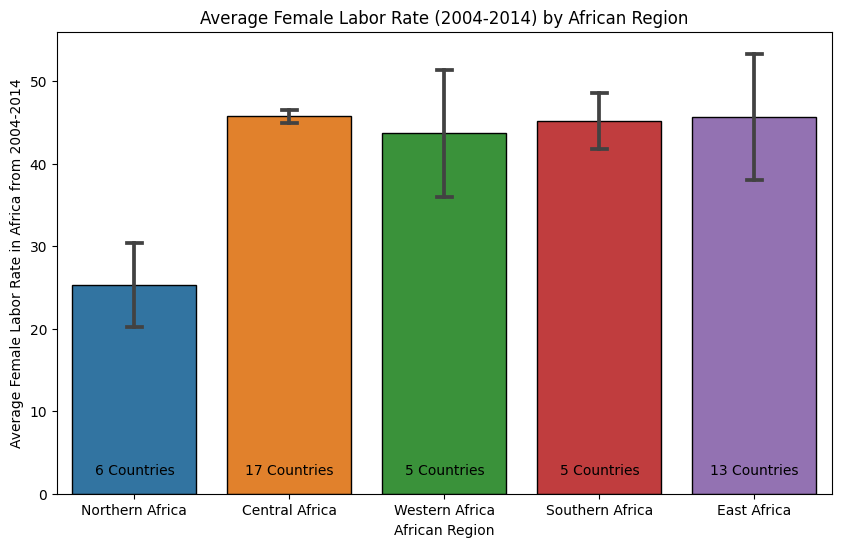

In [ ]:
# Analysis of female labor statistics by African region
region = africa_df[africa_df['Indicator Name'] == 'Labor force, female (% of total labor force)']
region['Female Labor Force 2004-2014'] = region[years].mean(axis=1, skipna=True)
region_counts = region.groupby('Region').size().reset_index(name='Number of Countries')
region = region[['Region', 'Female Labor Force 2004-2014']]

# create bar graph
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Region', y='Female Labor Force 2004-2014', data=region, errorbar='sd', capsize=0.1, edgecolor='black')

# display number of countries
for i, v in enumerate(region_counts['Number of Countries']):
    ax.text(i, 2, f'{v} Countries', ha='center', va='bottom')

# Adding labels and title
plt.xlabel('African Region')
plt.ylabel('Average Female Labor Rate in Africa from 2004-2014')
plt.title('Average Female Labor Rate (2004-2014) by African Region')
plt.show()

Likewise, the results were interesting but not terribly informative. There was little difference in female labor participation across each of the African sub-regions, with the exception of Northern Africa. There are numerous reasons for Northern Africa having much lower participation. It could be that agriculture is less prevalent in Northern Africa. It is also likely due to religion—how much of Northern African is Muslim and has different expectations and rules for women. This is something that we would have loved to look into but didn't have the data for, unfortunately.

#### 3.2.2.5 Several Indicators over Map of Africa
Finally, we wanted to visualize how each of our features change over the African landscape, since it is clear that even sub-regional groupings are not sufficient. To do this, we imported map data for the African continent and merged that with our dataset to plot key features for each country. For African countries in which we had no data, we shaded them gray.

<ipython-input-116-ed71958760de>:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/pyt

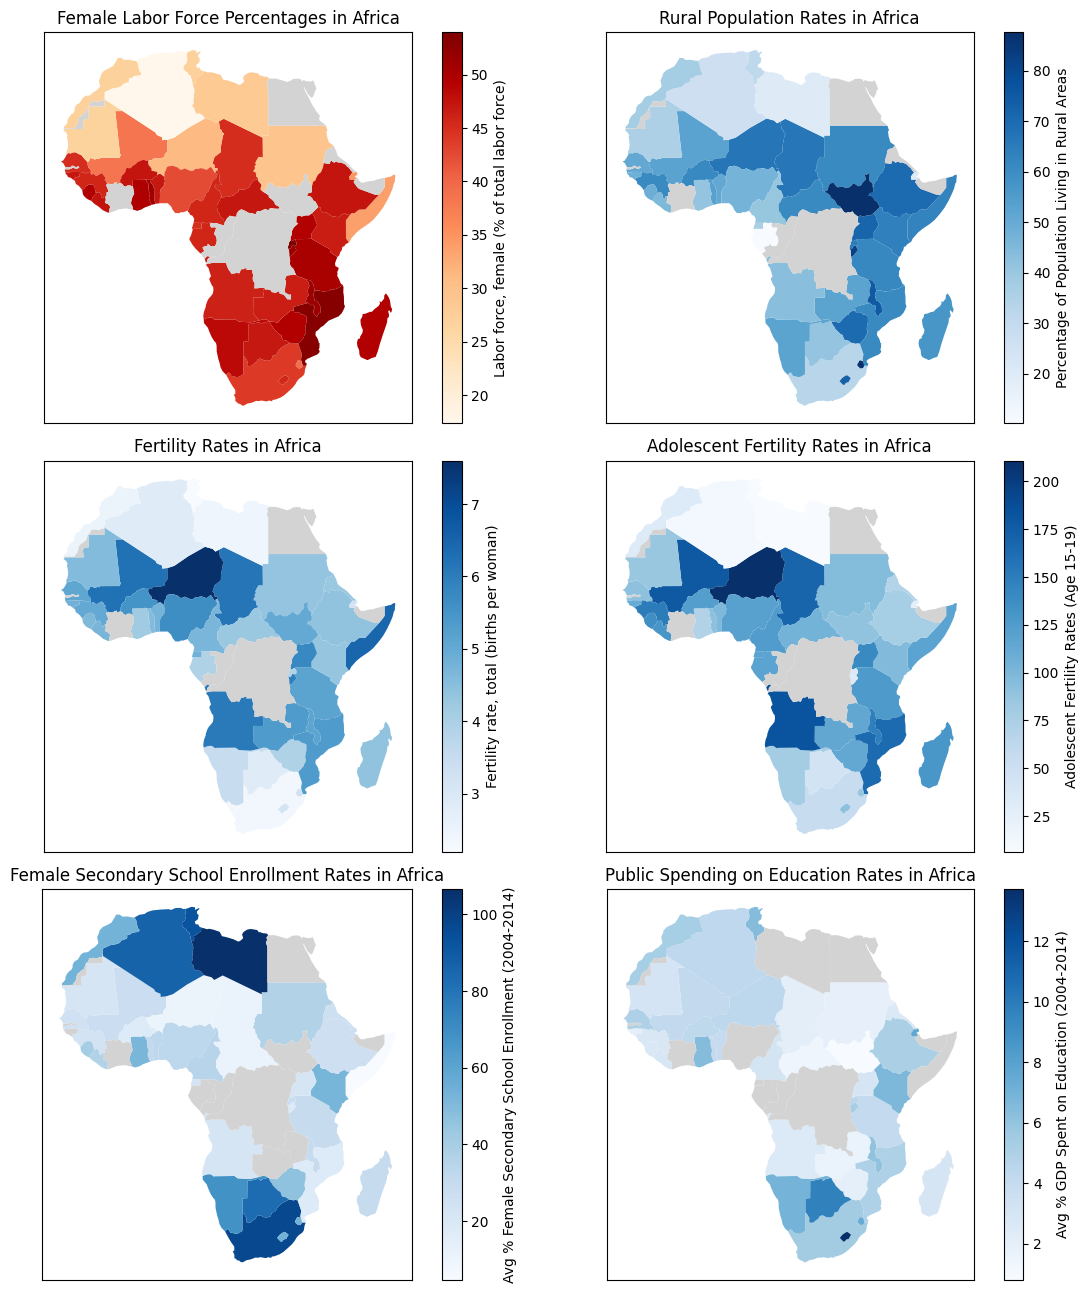

In [ ]:
# map data for African continent
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world.query('continent == "Africa"')

# manual cleaning to better merge
africa['name'] = africa['name'].replace('eSwatini', 'Swaziland')
africa['name'] = africa['name'].replace('Central African Rep.', 'Central African Republic')
africa['name'] = africa['name'].replace('Eq. Guinea', 'Equatorial Guinea')
africa['name'] = africa['name'].replace('S. Sudan', 'South Sudan')

# merge our dataset with map dataset
africa_merged = africa.merge(africa_df, how='left', left_on='name', right_on='Country Name')

# Clean up and average some of our important features that we want to display

# 2015 female labor %
africa_female_labor = africa_merged[(africa_merged['Indicator Name'] == 'Labor force, female (% of total labor force)') | (africa_merged['Indicator Name'].isnull())]
africa_female_labor_2014 = africa_female_labor[['name', 'iso_a3', 'gdp_md_est', 'geometry', '2014']].reset_index()
africa_female_labor_2014 = africa_female_labor_2014.drop(columns='index')

# 2015 fertility rates
africa_merged_fertility = africa_merged[(africa_merged['Indicator Name'] == 'Fertility rate, total (births per woman)') | (africa_merged['Indicator Name'].isnull())]
africa_merged_fertility_2014 = africa_merged_fertility[['pop_est', 'name', 'iso_a3', 'gdp_md_est', 'geometry', '2015']].reset_index()
africa_merged_fertility_2014 = africa_merged_fertility_2014.drop(columns='index')

# Average secondary school female enrollment rates from 2004-2014
africa_female_school = africa_merged[(africa_merged['Indicator Name'] == 'School enrollment, secondary, female (% gross)') | (africa_merged['Indicator Name'].isnull())]
enrollment_columns = [str(year) for year in range(2004, 2015)]
africa_female_school['Average Enrollment 2004-2014'] = africa_female_school[enrollment_columns].mean(axis=1, skipna=True)
africa_female_school = africa_female_school[['name', 'iso_a3', 'gdp_md_est', 'geometry', 'Average Enrollment 2004-2014']].reset_index()
africa_female_school = africa_female_school.drop(columns='index')

# Adolescent Fertility Rates
africa_female_adol_fert = africa_merged[(africa_merged['Indicator Name'] == 'Adolescent fertility rate (births per 1,000 women ages 15-19)') | (africa_merged['Indicator Name'].isnull())]
africa_female_adol_fert['Adolescent Fertility 2004-2014'] = africa_female_adol_fert[enrollment_columns].mean(axis=1, skipna=True)
africa_female_adol_fert = africa_female_adol_fert[['name', 'iso_a3', 'gdp_md_est', 'geometry', 'Adolescent Fertility 2004-2014']].reset_index()
africa_female_adol_fert = africa_female_adol_fert.drop(columns='index')

# Public Spending on Education
africa_education = africa_merged[(africa_merged['Indicator Name'] == 'Public spending on education, total (% of GDP)') | (africa_merged['Indicator Name'].isnull())]
africa_education['Public Spending Education 2004-2014'] = africa_education[enrollment_columns].mean(axis=1, skipna=True)
africa_education = africa_education[['name', 'iso_a3', 'gdp_md_est', 'geometry', 'Public Spending Education 2004-2014']].reset_index()
africa_education = africa_education.drop(columns='index')

# Rural Population
africa_rural = africa_merged[(africa_merged['Indicator Name'] == 'Rural population') | (africa_merged['Indicator Name'].isnull())]
africa_rural_2014 = africa_rural[['pop_est', 'name', 'iso_a3', 'gdp_md_est', 'geometry', '2014']].reset_index()
africa_rural_2014['Percent Rural Population'] = africa_rural_2014.apply(lambda x: ((x['2014']) / x['pop_est']) * 100
                                       if pd.notnull(x['2014']) and pd.notnull(x['pop_est'])
                                       else None, axis=1)
africa_rural_2014 = africa_rural_2014[['name', 'iso_a3', 'gdp_md_est', 'geometry', 'Percent Rural Population']].reset_index()
africa_rural_2014 = africa_rural_2014.drop(columns='index')

# create 3x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(12, 13))
for i in range(3):
  for j in range(2):
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])

# plot female labor rates
africa_female_labor_2014.plot(column="2014", cmap="OrRd", legend=True, ax=axs[0, 0], missing_kwds={'color': 'lightgray', 'label': 'No Data'}, legend_kwds={'label': "Labor force, female (% of total labor force)"})
axs[0, 0].set_title('Female Labor Force Percentages in Africa')

# plot overall fertility rates
africa_merged_fertility.plot(column="2014", cmap="Blues", legend=True, ax=axs[1, 0], missing_kwds={'color': 'lightgray', 'label': 'No Data'}, legend_kwds={'label': "Fertility rate, total (births per woman)"})
axs[1, 0].set_title('Fertility Rates in Africa')

# plot female secondary school rates
africa_female_school.plot(column="Average Enrollment 2004-2014", cmap="Blues", legend=True, ax=axs[2, 0], missing_kwds={'color': 'lightgray', 'label': 'No Data'}, legend_kwds={'label': "Avg % Female Secondary School Enrollment (2004-2014)"})
axs[2, 0].set_title('Female Secondary School Enrollment Rates in Africa')

# plot female adolescent fertility rates
africa_female_adol_fert.plot(column='Adolescent Fertility 2004-2014', cmap="Blues", legend=True, ax=axs[1, 1], missing_kwds={'color': 'lightgray', 'label': 'No Data'}, legend_kwds={'label': "Adolescent Fertility Rates (Age 15-19)"})
axs[1, 1].set_title('Adolescent Fertility Rates in Africa')

# plot public spending on education
africa_education.plot(column='Public Spending Education 2004-2014', cmap="Blues", legend=True, ax=axs[2, 1], missing_kwds={'color': 'lightgray', 'label': 'No Data'}, legend_kwds={'label': "Avg % GDP Spent on Education (2004-2014)"})
axs[2, 1].set_title('Public Spending on Education Rates in Africa')

# plot percent rural population
africa_rural_2014.plot(column='Percent Rural Population', cmap="Blues", legend=True, ax=axs[0, 1], missing_kwds={'color': 'lightgray', 'label': 'No Data'}, legend_kwds={'label': "Percentage of Population Living in Rural Areas"})
axs[0, 1].set_title('Rural Population Rates in Africa')

# show the graph
plt.tight_layout()
plt.show()


These results are particularly interesting. Right away, we can see that a larger rural population co-occurs with more female labor participation (FLP). Education is a difficult category to summarize because it has two dichotomous effects: in Southern Africa, higher education rates correspond to more FLP (perhaps because women are working less agricultural jobs), whereas we see the opposite effect take place in Northern Africa. In certain countries, lesser fertility rates generally correspond to higher FLP, but this is not always the case. Either way, these maps demonstate the complexity and non-linearity of our features.

### 3.2.3 Heat Map over Female Indicators
To formalize some of these variable relationships, we constructed a heatmap. We took a step back to consider data for all of our continents rather than just Africa.

<ipython-input-117-4374de98f7b6>:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



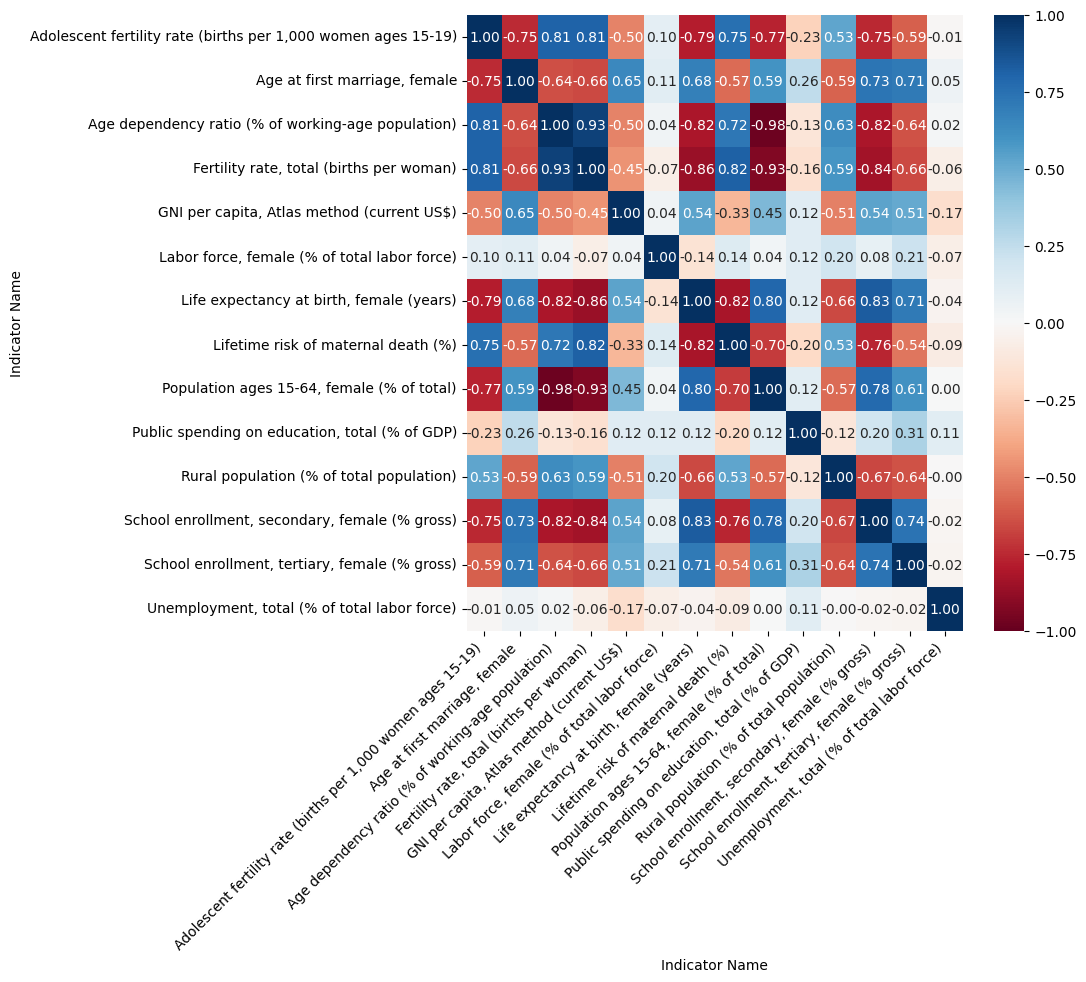

In [ ]:
# HEAT MAP: THE ROLE OF WOMEN IN A COUNTRY

plt.figure(figsize=(8,8))

fig = sns.heatmap(data = model2_df.corr(), cmap = 'RdBu', vmin = -1, vmax = 1, annot = True, fmt=".2f")
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

We can definitely see strong correlations between certain features, with some features even having correlation near 1. What was interesting, though, was how uncorrelated some statistics were that we intuitively thought would be. In particular, the fact that our target variable was seemingly uncorrelated with any of the other individual features stood out to us; we had wanted to choose a target that was complex enough that it wouldn't be strongly correlated with just one feature and instead would be influenced by a multitude of factors-and this heat map showed us that we had chosen wisely.

### 3.2.4 Boxplots over Female Indicators

In [ ]:
# SETUP FOR BOXPLOTS
model2_edit = model2_df.drop(columns = ['Country Name'])
model2_edit = model2_edit.reset_index(drop = True)

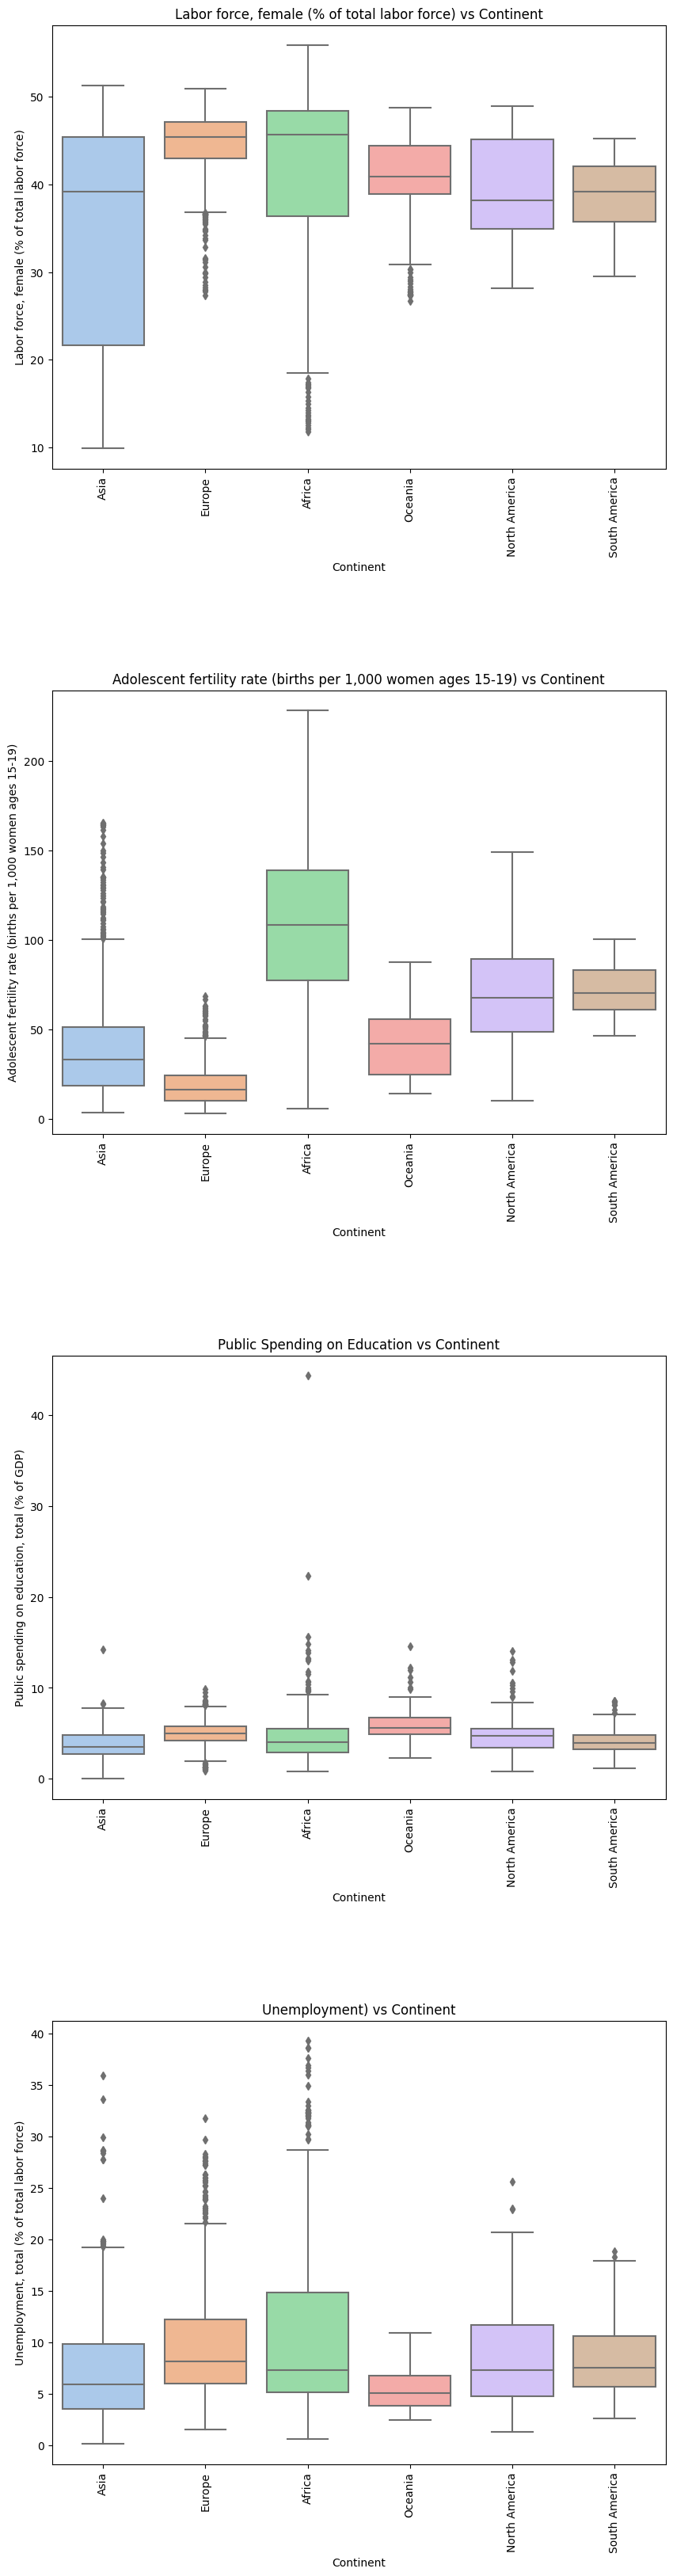

In [ ]:
# # Initializing the figures
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 40))
# # Initializing the boxplots
sns.boxplot(x="Continent", y="Labor force, female (% of total labor force)", data=model2_edit, palette = 'pastel', ax = axes[0])
sns.boxplot(x="Continent", y="Adolescent fertility rate (births per 1,000 women ages 15-19)", data=model2_edit, palette = 'pastel', ax = axes[1])
sns.boxplot(x="Continent", y="Public spending on education, total (% of GDP)", data=model2_edit, palette = 'pastel', ax = axes[2])
sns.boxplot(x="Continent", y="Unemployment, total (% of total labor force)", data=model2_edit, palette = 'pastel', ax = axes[3])

# # Setting descriptive titles
axes[0].set_title("Labor force, female (% of total labor force) vs Continent")
axes[1].set_title("Adolescent fertility rate (births per 1,000 women ages 15-19) vs Continent")
axes[2].set_title("Public Spending on Education vs Continent")
axes[3].set_title("Unemployment) vs Continent")


# # Axes label formatting
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[2].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[3].get_xticklabels(), rotation=90, ha='center')

plt.subplots_adjust(hspace=0.5)

# # Displaying plot
plt.show()

In addition to the bar graph shown earlier, we wanted to create box and whisker plots for a better side by side comparison of a multitude of variables for all continents. This better allowed us to see whether there may be a positive or negative relationship on a continent by continent basis. For example, we can see that Europe has a much more distinctly inverse relationship betwen adolescent fertility rate and female labor force participation than other continents such as North and South America.

## 3.3 Interactive Data Visualization

We wanted to design interactive visualizations in order to drive a deeper understanding into individual country data. To do so, we installed the Plotly library, a high-level interface for creating various interactive visualizations.

Note that these visualizations simply display the raw data, not any model predictions or outputs.

In each of the two visualizations below, you (the viewer) are able to:


*   Hover over an individual bubble to view its numerical statistics
*   Select a new window by dragging your pointer over the desired window/range



In [ ]:
!pip install plotly
import plotly.express as px

### 3.3.1 Female Labor Force Participation vs. Tertiary School Enrollment


This interactive figure visualizes the relationship between female labor force participation and tertiary school enrollment. It selects the top and bottom 5 countries based on tertiary school enrollment within each continent to avoid overcrowding of the visualization. Further, the bubble sizes reflect each country's Gross National Income (GNI) per capita.

In [ ]:
# Drop nulls
model2_df_no_null = model2_df.dropna(subset=['School enrollment, tertiary, female (% gross)', 'GNI per capita, Atlas method (current US$)', 'Labor force, female (% of total labor force)', 'Continent' ])

# Sort the DataFrame within each continent based on 'Labor force, female (% of total labor force)'
combined_df_sorted = model2_df_no_null.groupby('Continent', as_index=False).apply(lambda x: x.sort_values(by=['School enrollment, tertiary, female (% gross)'], ascending=False))

# Select the top 5 and bottom 5 countries within each continent
top_bottom_5_countries = combined_df_sorted.groupby('Continent', as_index=False).apply(lambda x: pd.concat([x.head(5), x.tail(5)]))

# Reset the index after grouping
filtered_combined_df = top_bottom_5_countries.reset_index(drop=True)

# Create an interactive scatter plot
fig = px.scatter(filtered_combined_df,
                 x='School enrollment, tertiary, female (% gross)',
                 y='Labor force, female (% of total labor force)',
                 color='Continent',
                 size='GNI per capita, Atlas method (current US$)',
                 hover_name='Country Name',
                 title='Labor Force Participation vs. Tertiary School Enrollment, sized by GNI',
                 labels={'School enrollment, tertiary, female (% gross)': 'Tertiary School Enrollment (% Female)',
                         'GNI per capita, Atlas method (current US$)': 'GNI per capita (US$)',
                         'Labor force, female (% of total labor force)': 'Labor Force, Female (% of Total Labor Force)',
                         'Continent': 'Continent'},
                 size_max=40)

# Change size
fig.update_layout(width=800, height=600)

# Show the plot
fig.show()

### 3.3.2 Female Labor Force Participation vs. Adolescent Fertility Rate


This interactive figure visualizes the relationship between female labor force participation and adolescent fertility rate. It selects the top and bottom 5 countries based on adolescent fertility rate within each continent to avoid overcrowding of the visualization. Further, the bubble sizes reflect each country's Gross National Income (GNI) per capita.

In [ ]:
# Drop nulls
model2_df_no_null = model2_df.dropna(subset=["Adolescent fertility rate (births per 1,000 women ages 15-19)", 'GNI per capita, Atlas method (current US$)', 'Labor force, female (% of total labor force)', 'Continent' ])

# Sort the DataFrame within each continent based on 'Labor force, female (% of total labor force)'
combined_df_sorted = model2_df_no_null.groupby('Continent', as_index=False).apply(lambda x: x.sort_values(by=["Adolescent fertility rate (births per 1,000 women ages 15-19)"], ascending=False))

# Select the top 5 and bottom 5 countries within each continent
top_bottom_5_countries = combined_df_sorted.groupby('Continent', as_index=False).apply(lambda x: pd.concat([x.head(5), x.tail(5)]))

# Reset the index after grouping
filtered_combined_df = top_bottom_5_countries.reset_index(drop=True)

# Create an interactive scatter plot
fig = px.scatter(filtered_combined_df,
                 x="Adolescent fertility rate (births per 1,000 women ages 15-19)",
                 y='Labor force, female (% of total labor force)',
                 color='Continent',
                 size='GNI per capita, Atlas method (current US$)',
                 hover_name='Country Name',
                 title='Labor Force Participation vs. Adolescent fertility rate, sized by GNI',
                 labels={"Adolescent fertility rate (births per 1,000 women ages 15-19)": "Adolescent fertility rate",
                         'GNI per capita, Atlas method (current US$)': 'GNI per capita (US$)',
                         'Labor force, female (% of total labor force)': 'Labor Force, Female (% of Total Labor Force)',
                         'Continent': 'Continent'},
                 size_max=40)

# Change size
fig.update_layout(width=800, height=600)

# Show the plot
fig.show()

# Part 4: Feature Engineering & Preprocessing

Now that we visualized our data, we noticed that it was important to include regionality in our data. We did this by performing a one-hot encoding of Continent and removing the Country column. Also, we noticed that many of our features had null data. Knowing that we couldn't have null values in our machine learning matrix, we dropped any rows which contained null values. This drastically cut down the size of our dataset to 454 rows.

## 4.1 Preprocessing and One-Hot Encoding


In [ ]:
# MODEL SETUP

# Drop country name
model2_df_encoded = model2_df.drop('Country Name', axis=1)
model2_df_encoded = pd.get_dummies(model2_df_encoded, columns=['Continent'])

# drop rows with null values
model2_df_no_null = model2_df_encoded.dropna()

## 4.2 Creating Training and Testing Data

In order to use any sort of model, we needed train and test data so that we can evaluate the performace of the model. For the split, we followed the standard procedure we've been using in class with an 80/20 split and a random seed of 42 for reproducibility.

In [ ]:
# Extract features
features_model2_df = model2_df_no_null.drop(columns = ['Labor force, female (% of total labor force)'])

# Extract target
target_model2 = model2_df_no_null['Labor force, female (% of total labor force)']


In [ ]:
# Conduct 80/20 train-test split with random_state = seed = 42
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features_model2_df, target_model2, train_size = 0.8, random_state = seed)

## 4.3 PCA

We now needed to standardize data using a standard scaler before doing PCA, as we have done in class. PCA needs all our data to be scaled, otherwise the results could become skewed and inaccurate.

In [ ]:
# Initializing scaler
scaler = StandardScaler()

# Fitting and transforming on the training set
X_train_scaled = scaler.fit_transform(X_train)

# Initializing the PCA object
pca = PCA()

# Fitting the PCA object on the scaled training set
X_train_initial_fit = pca.fit(X_train_scaled)

In [ ]:
# Initializing the explained_variance_ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculating the cumulative sum
cum_evr = np.cumsum(explained_variance_ratios)

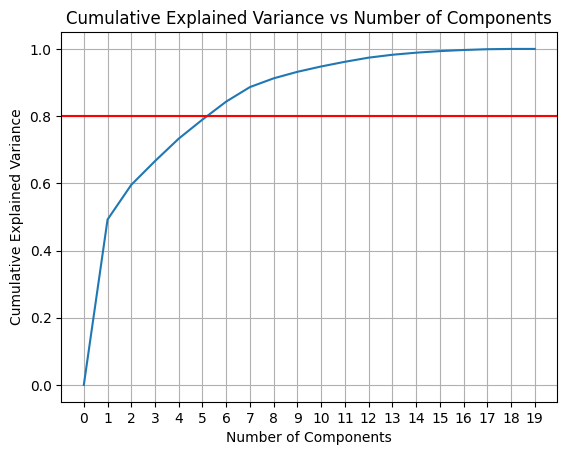

In [ ]:
# Plotting the explained variance vs number of components plot
cum_evr = np.insert(cum_evr, 0, 0) # dummy variable so number of components starts at 1
plt.plot(cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.xticks(np.arange(0, len(explained_variance_ratios)+1, 1))
plt.grid()
plt.show()

From the graph, we used 5 as the ideal number of components (reduced down from 19)

In [ ]:
# Fitting and transforming the train and test data set using the updated PCA object with the ideal number of components
X_test_scaled = scaler.transform(X_test)
pca_final = PCA(n_components = 5)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# Part 5: Modelling

## 5.1 Linear Regression
We decided to do linear regression for our first model, to see if we could determine a set of weights that accurately predict female labor participation.

In [ ]:
# Fit a linear regression model on PCA-transformed training data
reg = linear_model.LinearRegression()
reg.fit(X_train_pca, y_train)

# Predict on transformed test data using the linear regression model
y_pred_lin_reg_onehot = reg.predict(X_test_pca)

# R^2 value calculation
lin_reg_score_test = reg.score(X_test_pca, y_test)
lin_reg_score_train = reg.score(X_train_pca, y_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lin_reg_onehot)

print('Test Set R^2 value: ' + str(lin_reg_score_test))
print('Training Set R^2 value: ' + str(lin_reg_score_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.16791747088000852
Training Set R^2 value: 0.17999379233518198
Mean Squared Error: 31.370959565096324


## 5.2 Readjusting Data
As shown by our R^2 value and mean squared error, our linear regression model was not very accurate. We thought that this could be due to the dropping of null columns, which drastically cut down the size of our dataset. Therefore, we decided to try to impute the null values rather than naively dropping the rows.

We did this by creating a linear regression model for each country-indicator pair across all of the years. Since we have datapoints across time, we figured that linear regression would be more accurate than just using Simple Imputer with the mean/median/mode. However, we figured that we should only perform this type of linear regression if we had more than 5 data points for each country-feature pair across time, since otherwise the linear regression will be massively influenced by 1-2 data points. In the case where we had 5 or less data points, we took the mean to fill in each value. Lastly, we made sure that our linear regression model didn't give us impossible values by replacing negatives (which do not make sense in the context of GNI, fertility, employment, etc...) with the mean of the row, too.

We know that this kind of interpolation is prone to errors, but we were willing to take the accuracy tradeof if that meant increasing the size of our dataset. With this method, we were able to keep more than 3432 rows in our matrix compared to the 454 before.

In [ ]:
# Fixing nulls with linear regression
model2_new_df = filtered_df[filtered_df['Indicator Name'].isin(model2_indicators)]
years_to_drop = [str(year) for year in range(1980, 1991)]
model2_new_df = model2_new_df.drop(columns=years_to_drop)
model2_new_df = model2_new_df.drop(columns = ['2015'])

# Drop rows where all values are null
model2_new_df = model2_new_df.dropna(subset=model2_new_df.columns[2:-1], how='all')

# Create new data frame
filled_data = pd.DataFrame()

# Group the data by 'Country Name' and 'Indicator Name'
grouped_data = model2_new_df.groupby(['Country Name', 'Indicator Name'])

# Iterate through each group
for (country, indicator), group_df in grouped_data:
    # Extract years and values
    years = group_df.columns[2:-1].astype(int)
    target_row = group_df.iloc[:, 2:-1].values[0]

    # Linear regression model
    model = LinearRegression()

    # Find indices of missing values
    missing_indices = pd.isnull(target_row)

    if np.sum(missing_indices) > 0:
      if np.sum(~missing_indices) > 5:
        # Exclude missing values for training
        train_indices = ~missing_indices
        train_years = years[train_indices].values.reshape(-1, 1)
        train_values = target_row[train_indices].reshape(-1, 1)

        # Fit the linear regression model
        model.fit(train_years, train_values)

        # Predict missing values
        pred_values = model.predict(years[missing_indices].values.reshape(-1, 1))
        pred_values[pred_values < 0] = np.nanmean(target_row)

        # Replace missing values with predicted values
        target_row[missing_indices] = pred_values.flatten()
      else:
        target_row[missing_indices] = np.nanmean(target_row)

    # Combine the results for the current group
    filled_group_df = pd.DataFrame({'Country Name': [country],
           'Indicator Name': [indicator],
           'Continent': [group_df['Continent']]})
    filled_group_df = pd.concat([filled_group_df, pd.DataFrame(target_row.reshape(1, -1), columns=years)], axis=1)

    # Append the filled group data to the final DataFrame
    filled_data = pd.concat([filled_data, filled_group_df])

# set our model equal to this interpolated data
model2_filled_df = filled_data

Now that we imputed the values, we had to re-process the data by transposing it and adding the continent data.

In [ ]:
# Transpose model 2 df so indicators are columns
model2_filled_transposed = model2_filled_df.pivot_table(index=['Country Name'], columns='Indicator Name')
d = {}
for i in model2_filled_transposed.columns.levels[0]:
    d[i] = model2_filled_transposed[i]
model2_filled = pd.concat(d.values()).reset_index()

# add continent data
model2_filled.dropna(inplace=True)
model2_filled['Continent'] = model2_filled['Country Name'].apply(country_to_continent)
model2_filled = model2_filled.dropna(subset=['Continent'])

# drop country name and do one-hot-encoding of continent
model2_filled = model2_filled.drop('Country Name', axis=1)
model2_filled = pd.get_dummies(model2_filled, columns=['Continent'])

<ipython-input-132-84b96cba0a39>:2: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.



Now, we recreated our linear regression model to see if we could get better accuracy.

In [ ]:
# Extract features
features_model2_filled_df = model2_filled.drop(columns = ['Labor force, female (% of total labor force)'])

# Extract target
target_model2_filled = model2_filled['Labor force, female (% of total labor force)']


In [ ]:
# Conduct 80/20 train-test split with random_state = seed = 42
seed = 42
X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(features_model2_filled_df, target_model2_filled, train_size = 0.8, random_state = seed)

In [ ]:
# Initializing scaler
scaler = StandardScaler()

# Fitting and transforming on the training set
X_train_filled_scaled = scaler.fit_transform(X_train_filled)

# Initializing the PCA object
pca = PCA()

# Fitting the PCA object on the scaled training set
X_train_filled_initial_fit = pca.fit(X_train_filled_scaled)

In [ ]:
# Initializing the explained_variance_ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculating the cumulative sum
cum_evr = np.cumsum(explained_variance_ratios)

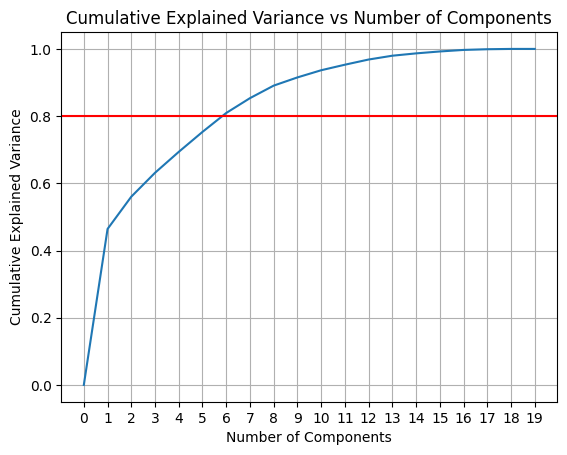

In [ ]:
# Plotting the explained variance vs number of components plot
cum_evr = np.insert(cum_evr, 0, 0) # dummy variable so number of components starts at 1
plt.plot(cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.xticks(np.arange(0, len(explained_variance_ratios)+1, 1))
plt.grid()
plt.show()

The ideal number of components is 6, as seen in our PCA graph

In [ ]:
# Fitting and transforming the train and test data set using the updated PCA object with the ideal number of components
X_test_filled_scaled = scaler.transform(X_test_filled)
pca_final = PCA(n_components = 6)
X_train_filled_pca = pca_final.fit_transform(X_train_filled_scaled)
X_test_filled_pca = pca_final.transform(X_test_filled_scaled)

In [ ]:
# Fit a linear regression model on PCA-transformed training data
reg = linear_model.LinearRegression()
reg.fit(X_train_filled_pca, y_train_filled)

# Predict on transformed test data using the linear regression model
y_pred_lin_reg_onehot = reg.predict(X_test_filled_pca)

# R^2 value calculation
lin_reg_score_test = reg.score(X_test_filled_pca, y_test_filled)
lin_reg_score_train = reg.score(X_train_filled_pca, y_train_filled)

# Evaluate the model
mse = mean_squared_error(y_test_filled, y_pred_lin_reg_onehot)

print('Test Set R^2 value: ' + str(lin_reg_score_test))
print('Training Set R^2 value: ' + str(lin_reg_score_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.11433892985309324
Training Set R^2 value: 0.12568356436499672
Mean Squared Error: 81.58778546719124


As shown by our lower R^2 value (.11 compared to .17) and higher error, it seems that our interpolation approach did not work as intended. While we have far more data, our relatively simple interpolation approach could have introduced too much randomness in the data, which made our model less accurately predictive. In order to interpolate the data in a more meaningful way, we would have to create much more complicated models and likely merge with other datasets. Since this would introduce too much overhead, we decided to stick with our original matrix of 454 rows.

## 5.2 Gradient Boosting Regression

Given the relatively low test set $R^{2}$ values in our linear regression above, we decided to test a Gradient Boosting Regression in order to increase model complexity and make better predictions of our target (female labor force participation). We also perform hyperparameter tuning on the `learning_rate`, `eta`, and `max_depth` of the model.

In [ ]:
# Instatiate a XGBRegressor model
xgbr = XGBRegressor(eta=0.1, max_depth=8, seed=42)

# Fit a model
xgbr.fit(X_train_pca, y_train)

# Predict the target variable for the training/test set
y_pred_xhbr_test = xgbr.predict(X_test_pca)
y_pred_xgbr_train = xgbr.predict(X_train_pca)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_xgbr_train)
r2_test = r2_score(y_test, y_pred_xhbr_test)
mse = mean_squared_error(y_test, y_pred_xhbr_test)

print('Test Set R^2 value: ' + str(r2_test))
print('Train Set R^2 value: ' + str(r2_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.1843222390007312
Train Set R^2 value: 0.9996860198270685
Mean Squared Error: 30.75247125488718


In [ ]:
# Define the parameter grid for XGradient Boosting Regression
param_dist = {
    'eta': [0.01, 0.1, 1],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.1, 0.3, 0.01]
}

# Create a XGradient Boosting Regression object
xgbr = XGBRegressor()

# Create a Grid Search Cross-Validation object
grid_search = GridSearchCV(xgbr, param_grid=param_dist, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the Grid Search object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [ ]:
# Create a new XGBRegressor with best params
xgb_best = XGBRegressor(learning_rate=best_params['learning_rate'],
                        eta=best_params['eta'],
                        max_depth=best_params['max_depth'],
                        random_state=42)
xgb_best.fit(X_train_pca, y_train)

# Make predictions
y_pred_xgbr_train_2 = xgb_best.predict(X_train_pca)
y_pred_xgbr_test_2 = xgb_best.predict(X_test_pca)

# Evaluate the model
r2_train = r2_score(y_train, y_pred_xgbr_train_2)
r2_test = r2_score(y_test, y_pred_xgbr_test_2)
mse = mean_squared_error(y_test, y_pred_xgbr_test_2)

print('Test Set R^2 value: ' + str(r2_test))
print('Train Set R^2 value: ' + str(r2_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.2725690126081348
Train Set R^2 value: 0.9999768577921486
Mean Squared Error: 27.425414298750983


Looking at the metrics, we see that the MSE is similar to that in Linear Regression. However, we newly observe a very high train set $R^{2}$ value, reflecting over-fitting of the model.

We attempt to address this in subsequent models.

## 5.3 Random Forest Regression

Although Random Forests are prone to over-fitting, we decided to test a Random Forest Regression and try tuning different hyperparameters. In our hyperparameter tuning, we varied the `num_estimators` and `max_depth` of the trees.

Also, since Random Forests are built on top of decision trees, which are scale invariant, we will not use the PCA-transformed test and training data.

In [ ]:
# Create the RandomForestRegressor
rfr_1 = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)

# Train the model
rfr_1.fit(X_train, y_train)

# Make predictions
y_pred_rf_train = rfr_1.predict(X_train)
y_pred_rf_test = rfr_1.predict(X_test)

# Evaluate the model
rfr_score_train = r2_score(y_train, y_pred_rf_train)
rfr_score_test = r2_score(y_test, y_pred_rf_test)
mse = mean_squared_error(y_test, y_pred_rf_test)

print('Test Set R^2 value: ' + str(rfr_score_test))
print('Train Set R^2 value: ' + str(rfr_score_train))
print('Mean Squared Error: ' + str(mse))


Test Set R^2 value: 0.44065616280413245
Train Set R^2 value: 0.8647591607146085
Mean Squared Error: 21.08823618519573


In [ ]:
# HYPERPARAMETER TUNING

# Define the parameter grid for Random Forest Regression
param_dist = {
    'n_estimators': [80, 100, 120],
    'max_depth': [6, 12, 15]
}

# Create a Random Forest Regression object
rfr_2 = RandomForestRegressor()

# Create a Grid Search Cross-Validation object
grid_search = GridSearchCV(rfr_2, param_grid=param_dist, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the Grid Search object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [ ]:
# Create new RandomForestRegressor with the best parameters
rfr_best = RandomForestRegressor(**best_params)
rfr_best.fit(X_train, y_train)

# Make predictions
y_pred_rf_train_2 = rfr_best.predict(X_train)
y_pred_rf_test_2 = rfr_best.predict(X_test)

# Evaluate the model
rfr_score_train = r2_score(y_train, y_pred_rf_train_2)
rfr_score_test = r2_score(y_test, y_pred_rf_test_2)
mse = mean_squared_error(y_test, y_pred_rf_test_2)

print('Test Set R^2 value: ' + str(rfr_score_test))
print('Train Set R^2 value: ' + str(rfr_score_train))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.5458491848173985
Train Set R^2 value: 0.9370253984754647
Mean Squared Error: 17.12227616966874


In the Random Forest Regression metrics, we see a reduction in the mean squared error as compared to Linear Regression and Gradient Boosting, but a similarly high test set $R^{2}$ value to Gradient Boosting.

Although the test set $R^{2}$ value is slightly lower in Random Forest Regression as compared to in Gradient Boosting, we still face the trouble of over-fitting. The question is whether the issue is with the model (being overly complex) or with the data (being difficult to generalize).

## 5.4 Neural Nets

While we were getting decent results with the Random Forest Regression Model, we wanted to see if we could improve even further with a neural net. We decided to try two different types of neural nets, with one being a simple feedforward neural net and the other being a more complex long short-term memory network. While these models are meant to produce results better than simpler linear regression models, we recognized that we don't have a large amount of data to train on which could hamper how well the model performs.

### 5.4.1 Simple Neural Net

For our simple feedforward model, we started with a few fully connected linear layers and went on to experiment with different hyperparameters to obtain the best output.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

In [ ]:
# Creating tensor from test and training data
X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train.values).float().to(device)
y_test_tensor = torch.from_numpy(y_test.values).float().to(device)

In [ ]:
y_train_tensor = y_train_tensor.unsqueeze(1)
y_test_tensor = y_test_tensor.unsqueeze(1)

In [ ]:
print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)

torch.Size([360, 19]) torch.Size([91, 19]) torch.Size([360, 1]) torch.Size([91, 1])


In [ ]:
# Defining the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(19, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 4)
        self.fc7 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        return x

In [ ]:
# Defining the loss function and optimizer by which we update the model
net = Net().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.006)

In [ ]:
# Training the neural network
n_epochs = 50
batch_size = 10
batch_start = torch.arange(0, len(X_train_tensor), batch_size)
best_mse = np.inf
mse_history = []

for epoch in range(n_epochs):
  running_loss = 0.0
  for start in batch_start:
      X_batch = X_train_tensor[start: start + batch_size].to(device)
      y_batch = y_train_tensor[start: start + batch_size].to(device)
      y_pred = net(X_batch).to(device)
      loss = loss_fn(y_pred, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss
  # print(f"Epoch {epoch}: {running_loss/len(batch_start)}")

y_pred = net(X_test_tensor)
mse = loss_fn(y_pred, y_test_tensor)
mse = float(mse)
r2_test = r2_score(y_test_tensor.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
print(f'R^2 test score: {r2_test}')
print(f'MSE Loss: {mse}')

R^2 test score: 0.12080441793113239
MSE Loss: 33.14720153808594


As you can see, our loss and R^2 score are not much better than our linear regression models, despite experimenting with epochs, learning rates, and the number of layers used. There could be a few reasons for this, including that a simple feedforward network might not be an optimal model for this use case, and the fact that we don't have a large amount of training data.

### 5.4.2 LSTM

In [ ]:
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
num_epochs = 150

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
      super(LSTM, self).__init__()
      # TODO - Initialize the model params #
      self.num_layers = num_layers
      self.hidden_dim = hidden_dim
      self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = False)
      self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      # TODO - Feed foward loop (Set the hidden and cell state to zero) #
      h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_dim).requires_grad_()
      c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_dim).requires_grad_()
      h0 = h0.to(device)
      c0 = c0.to(device)
      out, _ = self.lstm(x, (h0.detach(), c0.detach()))
      out = self.fc(out[:, -1, :])
      return out

In [ ]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
model.to(device)
Loss = nn.MSELoss(reduction = 'mean')
learning_rate = 1e-2
Optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
# Train the Model
train_loss = []
model.train()
for epoch in range(num_epochs):
  running_loss = 0
  inputs = X_train_tensor
  inputs.to(device)
  labels = y_train_tensor
  labels.to(device)
  inputs = inputs.reshape(len(inputs), 19, 1)

  outputs = model(inputs)
  loss = Loss(outputs, labels)
  Optimizer.zero_grad()
  loss.backward()
  Optimizer.step()
  train_loss.append(loss)
  running_loss += loss

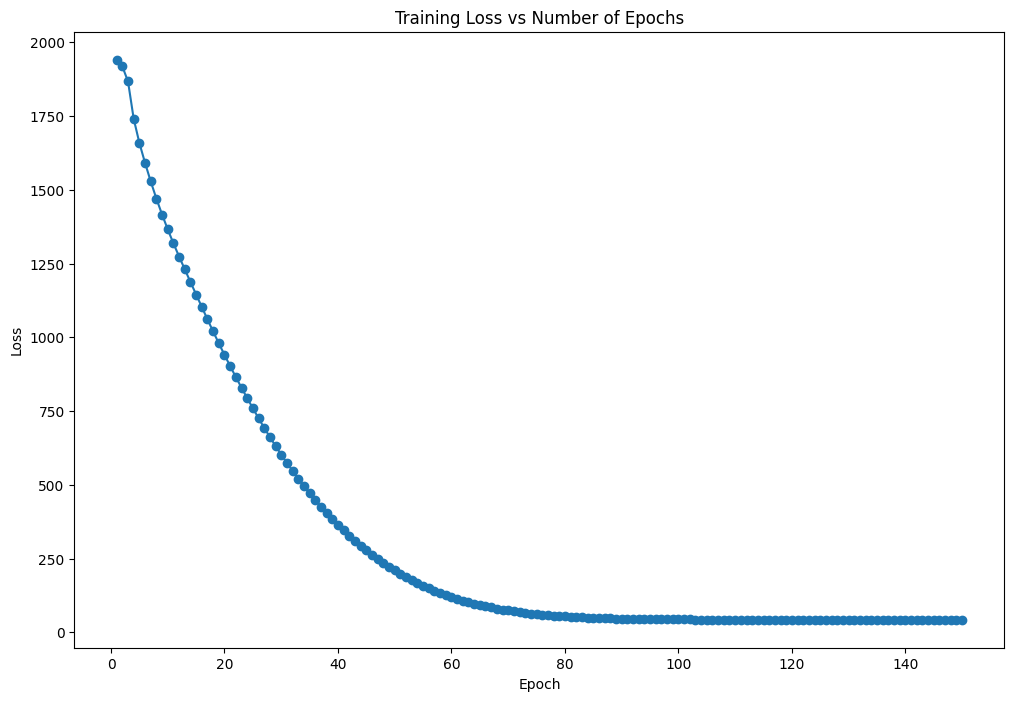

In [ ]:
train_loss_list = [x.detach().numpy() for x in train_loss]
plt.figure(figsize=(12, 8))

plt.plot(range(1, num_epochs + 1), train_loss_list, marker='o')
plt.title('Training Loss vs Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
#Testing
model.eval()
running_loss = 0
inputs = X_test_tensor
labels = y_test_tensor
inputs = inputs.reshape(len(inputs), 19, 1)
outputs = model(inputs)
loss = Loss(outputs, labels)
running_loss += loss
print(f'MSE Loss: {running_loss / len(inputs)}')


MSE Loss: 0.45195966958999634


As apparent from our MSE loss, the LSTM model works supremely well compared to all other models. We chose not to include an R^2 score as the scaling for an LSTM model would throw off the calculation, leading to an inaccurate representation of results. However, as seen in our training loss graph, we were able to get our loss significantly lower than any of our other models. We also had similar performance at the end of our training and during our testing, showing that the model was not overfit.

This makes sense given that LSTM models have historically been shown to perform better with time series data.

# Part 6: Applications and Extensions

We wanted to include a brief section on the potential business and political applications of the findings of our model.

After training several models to predict female labor force participation, we can extract the most important features from a given model in order to determine which features might have the strongest correlations with positive outcomes for female labor force participation. As shown in the barplot below for our Random Forest Regression, for example, we see that fertility rate, tertiary school enrollment, and rural population have the strongest correlations with female labor force participation. Another key observation is that regionality had little influence on female labor force participation, with the exception of Asia.

<BarContainer object of 19 artists>

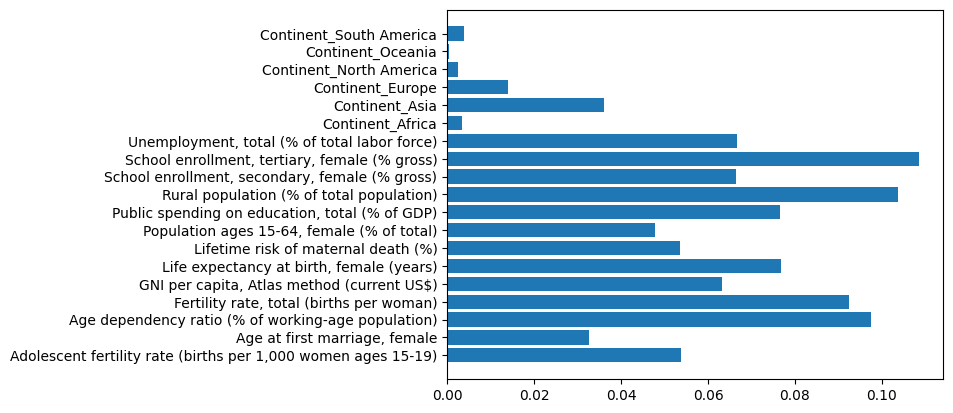

In [ ]:
# Visualizing feature importance of best model
plt.barh(features_model2_filled_df.columns.tolist(), rfr_best.feature_importances_)

Understanding the features that have the strongest correlations with female labor force participation can offer significant insights for actors in the real world, especially in the political arena.

Policymakers can use these findings to inform targeted interventions aimed at enhancing female labor force participation, which may increase overall economic propsperity and well-being. Data from the International Monetary Fund shows that closing the gender imbalance in the workforce has tangible economic benefits on the macroeconomic, sectoral, and firm levels.

As an example of an effective policy, increasing public spending on education and promoting higher tertiary enrollment may be identified as the most impactful allocation of funds. The weights of the model's features might be a useful proxy for determining how funds for a particular cause, such as female labor force enhancement, might be allocated.

Lastly, the model's revelation that regionality has a limited influence, except in Asia, opens avenues for deeper exploration into cultural or economic factors unique to the region. This might present policymakers with an argument in favor of region-specific policy formulations where there is otherwise a global default. Overall, the model's key features offer actionable intelligence for businesses and governments alike to promote gender equality and drive socio-economic development.

# Part 7: Conclusion

**Main takeaways**

While none of the features had an incredibly significant pull on target, we can see that some features definitely had a stronger correlation than others. Some of these, such as higher school enrollment for females and fertility rate, are to be expected when predicting the percentage of the labor force which is female. Others, such as rural population percentage were a bit more surprising but are still plausible; it could be that certain rural populations are not technically considered to be part of the labor force.

As for our models, our XGBRegressor and LSTM models produced the best results by far. Our XGBRegressor was able to produce a test R^2 value of ~0.5 and an MSE loss of ~19, and our LSTM was able to reduce our test loss to ~0.45. While the LSTM was performing significantly better than the XGBRegressor, the LSTM is a much more finnicky model and could be unreliable for any extrapolated data (especially given the small amount of training data we have). Overall we were able to achieve good results but had we had a more robust dataset, we may have been able achieve even better.

**Future Implications**

We would love to enhance our dataset further, whether through direct manipulation of our current dataset or through joining our current dataset with others of similar topics, to fill in some of the gaps that currently exist and make our data a bit more comprehensive.

It could also be of benefit to do some more preliminary statistical tests to see whether certain features are correlated at all before including them in the model-as including them when there is absolutely no correlation can just create noise and cause the model to perform worse than it should.

Lastly, we would of course love to try out a more diverse array of models with different parameters to see if any were more apt for our data.

**Team Reflection**

This was a super interesting project to work on! We all learned so much, as we were able to use pretty much everything we've learned throughout this class.

The data pre-processing and EDA tasks were definitely arduous, but all the pandas skills we developed at the beginning of the semester definitely made the process a lot smoother. Having this good foundation also made doing the EDA a lot more interesting, as we were able to push the bounds a bit more and dive into more complex analysis that we wouldn't have been able to do otherwise.

Overall, this project has pushed all of our understandings of the data and the content matter much further than we initially anticipated. There were many times we would create a graph/chart/model and the results would be entirely unexpected; we'd have to re-evaluate our thoughts and understand why the results were the way we were, and how we could adapt to them. It took a lot of effort, but we were constantly iterating on what we had to get to our final script in the form it is now.